<a href="https://colab.research.google.com/github/HCCREN/Efficiently-Serving-LLMs/blob/main/batching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

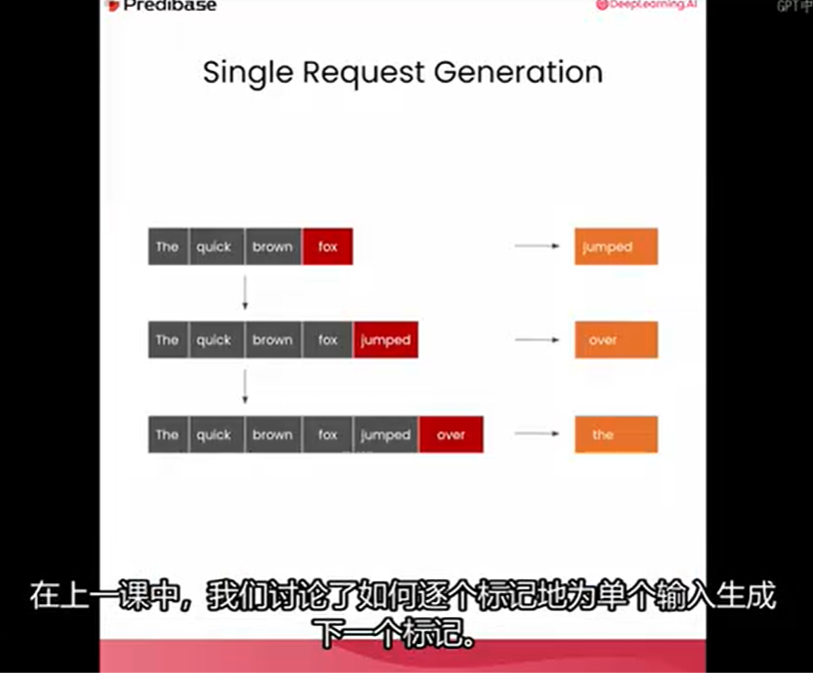

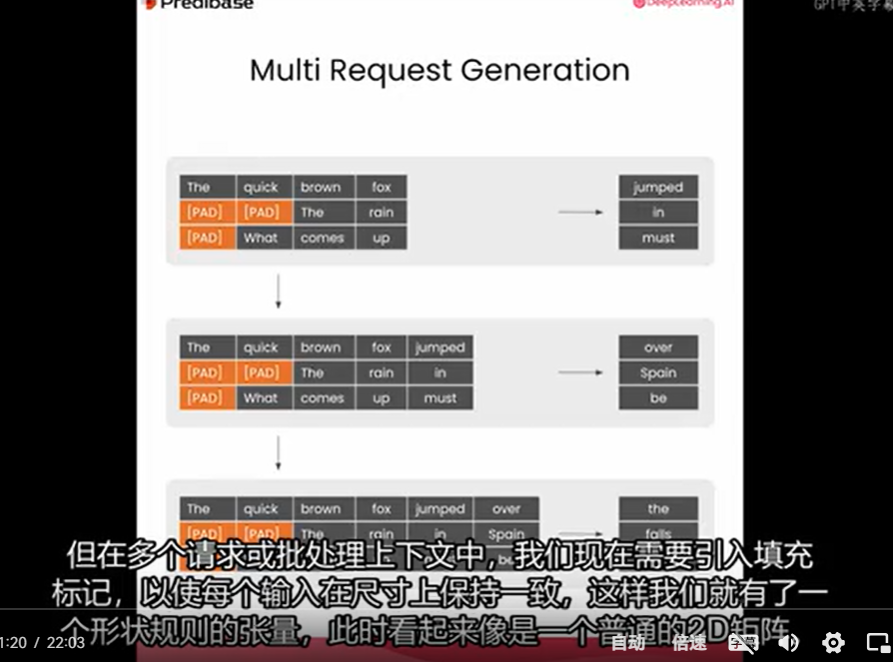

因此,为了引入这些新序列,雨,出现了什么,我们在左侧引
入了这些填充标记,其目的是确保整体上矩阵的形状是一
致的。

In [ ]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

扩展这个函数及其后续部分,以支持不仅
仅是单个输入,还支持多个输入,并看看如何优化其性能。

In [ ]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")


def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)


tokens = generate(inputs, max_tokens=10)
print(tokens)

 fence and ran to the other side of the fence


In [ ]:
#对模型和分词器进行一些小的修改,以引入一个填充标记。
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
#定义这个填充将被放置在哪里,如果它将被放置在输入序列的左侧,这样我们将有前导填充标记, 或者放在右侧,这意味着我们将有尾随填充标记。
# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

这在一定程度上取決于模型,也取決于你是在进行训练还
是推理
推理 = 希望向左进行填充,
训练 = 将在输入的右侧附加标记。

In [ ]:
# multiple prompts of varying lengths to send
# to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt") #新的参数padding equalstrue,它将使用我们之前从分词器添加的填充标记, 来填充我们的提示,使它们成为一个具有正常形状的单个张量。

In [ ]:
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])


In [ ]:
print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


In [ ]:
# position_ids tell the transformer the ordinal position
# of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference,
# we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [ ]:
# same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

In [ ]:
last_logits = logits[:, -1, :]
next_token_ids = last_logits.argmax(dim=1)

In [ ]:
print(next_token_ids)

tensor([13990,   319,   307])


In [ ]:
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' on', ' be']

我们处理批次中的所有元
素而不仅仅是第一个,并且我们将计算下一个标记ID而不
是单个的下一个标记ID,并且我们将沿着维度一计算下一
个标记ID,然后像以前一样返回下一个标记ID以及我们的
past key值。

In [ ]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

继续构建一个函数,用于生成某个限制(我们将
其定义为最大标记数)下的所有标记。

In [ ]:
def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])   #要做的第一件事是定义这个列表,生成的标记,它最初将只是我们批次中三个提示的三个空列表
    ]
    #使用它来生成位置ID,排除注意力掩码中对应于填充标记的零化元素
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    #扩展我们的批次,包括那些位置D,以及我们最初想要传递给模型的所有其他关键字参数。
    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }
    #使用了KV-缓存版本的这个过程,在我们称之为预填充步骤期间,我们会在一开始丢弃原始批次的输入
    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,  #在这里, unsqueeze 只是一个PyTorch辅助函数,将帮助我们使形状成为我们想要的确切形状。
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [ ]:
generated_tokens = generate_batch(inputs, max_tokens=10)
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



范围内的值,我们将从我们最初
的三个提示的原始列表中获取一个提示,并且我们将按顺
序进行,所以这里的模运算确保我们可以为任何给定的i值
获取一个提示

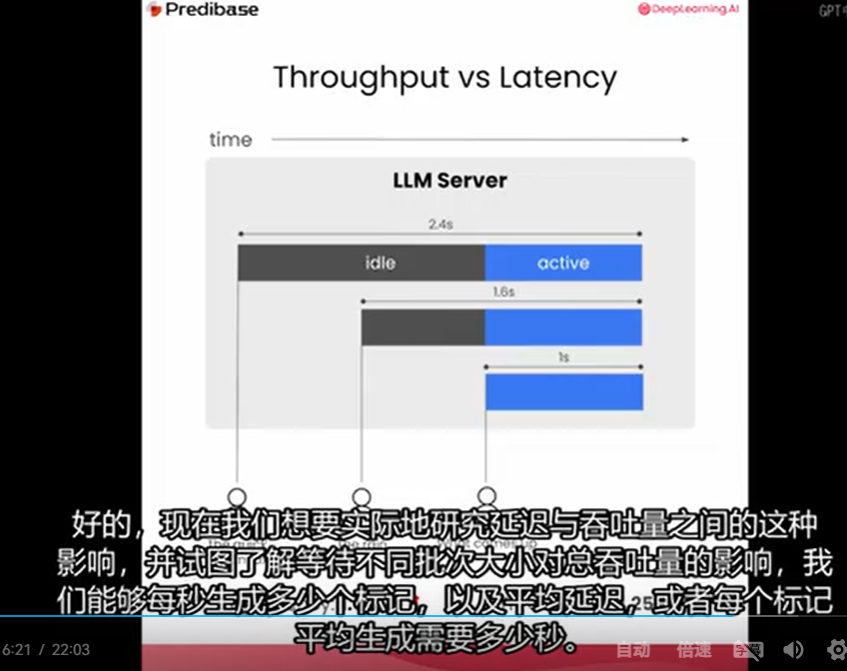

In [ ]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.6402914524078369
throughput 15.617887701600067
avg latency 0.0640291452407837

bs= 2
duration 1.03468656539917
throughput 19.329525161355733
avg latency 0.10346865653991699

bs= 4
duration 1.1179702281951904
throughput 35.779128094112586
avg latency 0.11179702281951905

bs= 8
duration 1.4658665657043457
throughput 54.57522660772345
avg latency 0.14658665657043457

bs= 16
duration 2.074995279312134
throughput 77.10860915936175
avg latency 0.20749952793121337

bs= 32
duration 3.332836151123047
throughput 96.01432098369774
avg latency 0.3332836151123047

bs= 64
duration 6.670635938644409
throughput 95.94287649433005
avg latency 0.6670635938644409

bs= 128
duration 11.474201202392578
throughput 111.55460649697314
avg latency 1.1474201202392578



In [ ]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

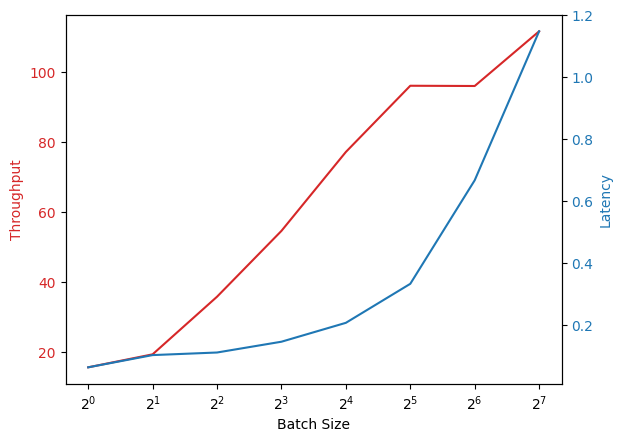

In [ ]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)